# Quantum Counting
Source: https://qiskit.org/textbook/ch-algorithms/quantum-counting.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer

from qiskit.visualization import plot_histogram

In [4]:
# EXAMPLE OF A GROVER ITERATION
"""Small circuit with 5/16 solutions"""
# Do circuit
qc = QuantumCircuit(4)
# Oracle
qc.h([2,3])
qc.ccx(0,1,2)
qc.h(2)
qc.x(2)
qc.ccx(0,2,3)
qc.x(2)
qc.h(3)
qc.x([1,3])
qc.h(2)
qc.mct([0,1,3],2)
qc.x([1,3])
qc.h(2)
# Diffuser
qc.h(range(3))
qc.x(range(3))
qc.z(3)
qc.mct([0,1,2],3)
qc.x(range(3))
qc.h(range(3))
qc.z(3)

qc.draw()

┌───┐┌───┐          ┌───┐┌───┐
q_0: ───────■──────────────■──────────────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├
            │  ┌───┐       │              │  ├───┤├───┤┌───┐  │  ├───┤├───┤
q_1: ───────■──┤ X ├───────┼──────────────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ┌───┐┌─┴─┐├───┤┌───┐  │  ┌───┐┌───┐┌─┴─┐├───┤├───┤├───┤  │  ├───┤├───┤
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤└───┘└───┘└───┘┌─┴─┐├───┤├───┤└─┬─┘├───┤├───┤└───┘┌─┴─┐├───┤└───┘
q_3: ┤ H ├───────────────┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ Z ├─────┤ X ├┤ Z ├─────
     └───┘               └───┘└───┘└───┘     └───┘└───┘     └───┘└───┘

In [5]:
#turn it into a function
def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    qc = QuantumCircuit(4)
    # Oracle
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    # Diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

In [9]:
print(example_grover_iteration())

                                             ┌───┐┌───┐          ┌───┐┌───┐
q_0: ───────■──────────────■──────────────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├
            │  ┌───┐       │              │  ├───┤├───┤┌───┐  │  ├───┤├───┤
q_1: ───────■──┤ X ├───────┼──────────────■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ┌───┐┌─┴─┐├───┤┌───┐  │  ┌───┐┌───┐┌─┴─┐├───┤├───┤├───┤  │  ├───┤├───┤
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤└───┘└───┘└───┘┌─┴─┐├───┤├───┤└─┬─┘├───┤├───┤└───┘┌─┴─┐├───┤└───┘
q_3: ┤ H ├───────────────┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ Z ├─────┤ X ├┤ Z ├─────
     └───┘               └───┘└───┘└───┘     └───┘└───┘     └───┘└───┘     


In [14]:
#create a controlled-Grover gate
grit = example_grover_iteration()
grit = grit.to_gate()
grit.label = 'Grover'

cgrit = grit.control()
type(cgrit)

qiskit.circuit.controlledgate.ControlledGate

In [16]:
#define a QFT function:

def swap_registers(circuit,n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2 ** (n - qubit), qubit, n)
        qft_rotations(circuit,n)

def qft(n):
    circuit = QuantumCircuit(4)
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [18]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = 'QFT-d'

In [19]:
#### PUTTING IT ALL TOGETHER ####

In [22]:
t= 4  # counting qubits
n = 4 # searching qubits
qc = QuantumCircuit(n+t, t)

#initialize qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# start controlled-Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2

#inverse QFT on counting qubits and measure
qc.append(qft_dagger, range(t))
qc.measure(range(t), range(t))

qc.draw(fold=-1)

┌───┐                                                                                                                                                                     ┌────────┐┌─┐         
q_0: ┤ H ├─────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0       ├┤M├─────────
     ├───┤     │                                                                                                                                                               │        │└╥┘┌─┐      
q_1: ┤ H ├─────┼──────────■──────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1       ├─╫─┤M├──────
     ├───┤     │          │          │                                                                                                                                         │  QFT-d │ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┼──────────┼──────────┼──────────■──────────■──────────■──────────■─────────────────────────────────────────────────────────────────────────────────────────────┤2       ├─╫──╫─┤M├───
     ├───┤     │          │          │          │          │          │          │                                                                                             │        │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────■──────────■──────────■──────────■──────────■──────────■──────────■──────────■─────┤3       ├─╫──╫──╫─┤M├
     ├───┤┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐└────────┘ ║  ║  ║ └╥┘
q_4: ┤ H ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├───────────╫──╫──╫──╫─
     ├───┤│         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         │           ║  ║  ║  ║ 
q_5: ┤ H ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├───────────╫──╫──╫──╫─
     ├───┤│  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover │           ║  ║  ║  ║ 
q_6: ┤ H ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├───────────╫──╫──╫──╫─
     ├───┤│         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         ││         │           ║  ║  ║  ║ 
q_7: ┤ H ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├───────────╫──╫──╫──╫─
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘           ║  ║  ║  ║ 
c: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                          0  1  2  3

#### Simulating

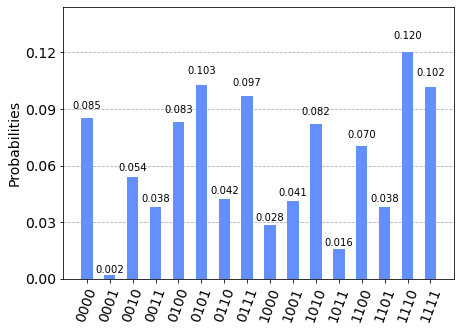

In [23]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)

qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)

hist = job.result().get_counts()
plot_histogram(hist)

In [24]:
measured_str = max(hist, key=hist.get)

In [25]:
measured_int = int(measured_str,2)
print(f"Register output = {measured_int}")

Register output = 14


#### Finding the number of solutions

In [26]:
theta = (measured_int / (2**t)) * math.pi * 2
print(f"Theta: {theta}")

Theta: 5.497787143782138


In [27]:
N = 2 ** n
M = N * (math.sin(theta/2)**2)
print(f"Number of solutions: {N - M}")

Number of solutions: 13.65685424949238


In [28]:
m = t - 1

err = (math.sqrt(2 * M * N) + N/(2**(m+1))) * (2 ** (-m))

print(f"Error: {err}")

Error: 1.2073922002923942


In [29]:
def calculate_M(measured_int, t, n):
    theta = (measured_int / (2 ** t)) * math.pi * 2
    print(f"Theta = {theta}")
    
    N = 2 ** n
    M = N * (math.sin(theta/2)**2)
    print(f"Number of solutions: {N - M}")
    
    m = t - 1
    err = (math.sqrt(2 * M * N) + N/(2**(m+1))) * (2**(-m))
    print(f"Error: {err}")

In [30]:
calculate_M(measured_int, t, n)

Theta = 5.497787143782138
Number of solutions: 13.65685424949238
Error: 1.2073922002923942
